In [1]:
import sys
sys.path.append("../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ExplicitModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.1306,), std=(0.3081,))])

mnist_dset_train = torchvision.datasets.MNIST('./data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('./data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
def evaluatePC2(model, loader, device, apply_activation_inverse = True, activation_type = "sigmoid", printing = True):
    # Evaluate Predictive Coding Model on Classification Task
    correct=0
    phase = 'Train' if loader.dataset.train else 'Test'
    
    for x, y in loader:
        if apply_activation_inverse:
            x = activation_inverse(x.view(x.size(0),-1).T, activation_type).to(device)
        else:
            x = x.view(x.size(0),-1).T.to(device)

        y = y.to(device)
        
        neurons = model.fast_forward(x)

        pred = torch.argmax(neurons[-1][:10,:], dim=0).squeeze()  
        correct += (y == pred).sum().item()

    acc = correct/len(loader.dataset) 
    if printing:
        print(phase+' accuracy :\t', acc)   
    return acc

In [5]:
def mysoftmax(x, dim = 0):
    return F.softmax(x, dim)

def kWTA(inp_vector, k = 1):
    tmpx = torch.clone(inp_vector)
    topval = tmpx.topk(k, dim=0)[0][k - 1]
    topval = topval.repeat(tmpx.shape[0], 1)
    comp = (inp_vector>=topval)
    return comp*inp_vector

def Sparsify_kWTA(inp_vector, sparsity = 0.1):
    k = int(inp_vector.shape[0] * sparsity)
    if k == 0:
        k = 1
    tmpx = torch.clone(inp_vector)
    topval = tmpx.topk(k, dim=0)[0][k - 1]
    topval = topval.repeat(tmpx.shape[0], 1)
    comp = (inp_vector>=topval)
    return comp*inp_vector

activation = Sparsify_kWTA
activation = torch.nn.LeakyReLU(0.0)
activation = torch.sigmoid

architecture = [784, 500, 50]
nc = 10
lambda_ = 0.9999
epsilon = 0.01
neural_lr_start = 0.1
neural_lr_stop = 0.00
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.005
neural_dynamic_iterations = 50

model = CorInfoMaxBiDirectional_wAutoGradV2(architecture, nc, lambda_, epsilon, activation, 
                                            optimizer_type = "sgd",
                                            optim_lr_ff = 0.01, optim_lr_fb = 0.001, 
                                            use_stepLR = True, sgd_weight_decay = 0.001, 
                                            stepLR_step_size = 10*3000)

In [6]:
x, y = next(iter(train_loader))
x = x.view(x.size(0),-1).T
x, y = x.to(device), y.to(device)
y_one_hot = F.one_hot(y, 10).to(device).T
neurons = model.init_neurons(x.size(1))
# neurons = model.fast_forward(x)
# mode = "train"
# if mode == "train":
#     neurons[-1] = y.to(torch.float)


neurons = model.run_neural_dynamics( x, y_one_hot, neurons, neural_lr_start, neural_lr_stop, lr_rule = neural_lr_rule,
                                    lr_decay_multiplier = neural_lr_decay_multiplier, 
                                    neural_dynamic_iterations = neural_dynamic_iterations)

# neurons[-1]

In [7]:
neurons[-1].shape

torch.Size([50, 20])

In [8]:
y

tensor([9, 8, 2, 3, 9, 1, 0, 3, 7, 7, 4, 9, 8, 1, 1, 7, 5, 8, 2, 1],
       device='cuda:0')

In [9]:
# neurons[-1][:,1]

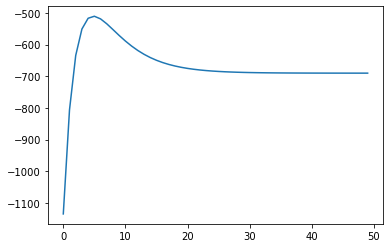

In [10]:
plt.plot(model.neural_dynamics_loss_list)

In [7]:
# F.softmax(neurons[0], 0)[:,0]

In [8]:
# torch.sum(F.softmax(neurons[0], 0), 0)

In [9]:
# optim_params = []
# for idx in range(len(model.Wff)):
#     for key_ in ["weight", "bias"]:
#         optim_params.append(  {'params': model.Wff[idx][key_], 'lr': lr_start["ff"]}  )

In [10]:
# optimizer = torch.optim.Adam(optim_params, maximize = True)

In [ ]:
model = CorInfoMaxBiDirectional_wAutoGradV2(architecture, nc, lambda_, epsilon, activation, 
                                            optimizer_type = "sgd",
                                            optim_lr_ff = 0.001, optim_lr_fb = 0.001, 
                                            use_stepLR = True, sgd_weight_decay = 0.001, 
                                            stepLR_step_size = 10*3000)

trn_acc_list = []
tst_acc_list = []

n_epochs = 50

for epoch_ in range(n_epochs):
    if epoch_ > 12:
        neural_lr_start = 0.05
    if epoch_ > 17:
        neural_lr_start = 0.03
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        #x = activation_inverse(x.view(x.size(0),-1).T, "sigmoid")
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        #y_one_hot = 0.94 * y_one_hot + 0.03 * torch.ones(*y_one_hot.shape, device = device)
        y_one_hot = 4*y_one_hot
        
        model.batch_step(  x, y_one_hot, neural_lr_start, neural_lr_stop, neural_lr_rule,
                           neural_lr_decay_multiplier, neural_dynamic_iterations,
                         )

    trn_acc = evaluatePC(model, train_loader, device, False, 
                         printing = False)
    tst_acc = evaluatePC(model, test_loader, device, False, 
                         printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [04:14, 11.78it/s]
2it [00:00, 10.90it/s]

Epoch : 1, Train Accuracy : 0.6232333333333333, Test Accuracy : 0.6273


3000it [04:00, 12.47it/s]
2it [00:00, 10.06it/s]

Epoch : 2, Train Accuracy : 0.5899, Test Accuracy : 0.5975


3000it [03:17, 15.22it/s]
1it [00:00,  9.54it/s]

Epoch : 3, Train Accuracy : 0.4869833333333333, Test Accuracy : 0.49


3000it [03:13, 15.52it/s]
1it [00:00,  9.42it/s]

Epoch : 4, Train Accuracy : 0.3580333333333333, Test Accuracy : 0.3471


3000it [03:52, 12.88it/s]
1it [00:00,  8.18it/s]

Epoch : 5, Train Accuracy : 0.22241666666666668, Test Accuracy : 0.2106


3000it [04:21, 11.45it/s]
2it [00:00, 14.27it/s]

Epoch : 6, Train Accuracy : 0.17601666666666665, Test Accuracy : 0.162


3000it [03:42, 13.46it/s]
2it [00:00, 11.79it/s]

Epoch : 7, Train Accuracy : 0.13541666666666666, Test Accuracy : 0.1233


3000it [03:50, 13.01it/s]
2it [00:00, 12.82it/s]

Epoch : 8, Train Accuracy : 0.1386, Test Accuracy : 0.1256


3000it [03:36, 13.87it/s]
1it [00:00,  9.24it/s]

Epoch : 9, Train Accuracy : 0.1127, Test Accuracy : 0.1023


3000it [03:46, 13.22it/s]
1it [00:00,  7.49it/s]

Epoch : 10, Train Accuracy : 0.10588333333333333, Test Accuracy : 0.0968


3000it [04:01, 12.43it/s]
2it [00:00, 12.84it/s]

Epoch : 11, Train Accuracy : 0.10956666666666667, Test Accuracy : 0.1003


3000it [03:52, 12.90it/s]
1it [00:00,  9.54it/s]

Epoch : 12, Train Accuracy : 0.11456666666666666, Test Accuracy : 0.1037


3000it [03:45, 13.29it/s]
2it [00:00, 10.67it/s]

Epoch : 13, Train Accuracy : 0.11175, Test Accuracy : 0.104


3000it [03:10, 15.77it/s]
1it [00:00,  9.96it/s]

Epoch : 14, Train Accuracy : 0.13473333333333334, Test Accuracy : 0.1397


3000it [03:41, 13.57it/s]
2it [00:00, 10.38it/s]

Epoch : 15, Train Accuracy : 0.0809, Test Accuracy : 0.0821


3000it [04:03, 12.32it/s]
2it [00:00, 10.43it/s]

Epoch : 16, Train Accuracy : 0.19675, Test Accuracy : 0.191


3000it [03:58, 12.55it/s]
1it [00:00,  8.68it/s]

Epoch : 17, Train Accuracy : 0.29568333333333335, Test Accuracy : 0.2889


3000it [03:34, 13.98it/s]
1it [00:00,  8.67it/s]

Epoch : 18, Train Accuracy : 0.06588333333333334, Test Accuracy : 0.0622


3000it [03:36, 13.83it/s]
1it [00:00,  9.91it/s]

Epoch : 19, Train Accuracy : 0.24258333333333335, Test Accuracy : 0.2314


3000it [03:04, 16.23it/s]
1it [00:00,  9.68it/s]

Epoch : 20, Train Accuracy : 0.22608333333333333, Test Accuracy : 0.2165


3000it [03:14, 15.40it/s]
1it [00:00,  9.22it/s]

Epoch : 21, Train Accuracy : 0.21498333333333333, Test Accuracy : 0.21


3000it [03:29, 14.31it/s]
2it [00:00, 12.64it/s]

Epoch : 22, Train Accuracy : 0.21088333333333334, Test Accuracy : 0.2086


3000it [03:16, 15.30it/s]
2it [00:00, 10.46it/s]

Epoch : 23, Train Accuracy : 0.18265, Test Accuracy : 0.1759


3000it [03:14, 15.45it/s]
1it [00:00,  9.99it/s]

Epoch : 24, Train Accuracy : 0.19068333333333334, Test Accuracy : 0.1838


3000it [03:16, 15.23it/s]
1it [00:00,  9.65it/s]

Epoch : 25, Train Accuracy : 0.19438333333333332, Test Accuracy : 0.1925


2886it [03:27, 17.07it/s]

In [ ]:
# def inverse_leaky_relu(x, negative_slope = 0.1):
#     out = torch.zeros(*x.shape)
#     out[x >]

In [ ]:
Wfb[1]['weight'] @ yy + Wfb[1]['bias']

In [ ]:
torch.clip(Wfb[1]['weight'] @ yy + Wfb[1]['bias'], 1e-3, 1-1e-3)

In [ ]:
model.Wfb[1]

In [ ]:
cc = 0
yy = torch.randn(10, 1).to(device)
yy[cc] = 4
Wfb = model.Wfb
out = torch.clip(Wfb[0]['weight'] @ activation_inverse(torch.clip(Wfb[1]['weight'] @ yy + Wfb[1]['bias'], 1e-3, 1-1e-3), 'sigmoid') + Wfb[0]['bias'], 1e-3, 1-1e-3).view(28 ,28)
out = torch2numpy(out)
plt.imshow(out)

In [ ]:
def accuracy_topk(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].flatten().float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
        
    result = [res_.item() for res_ in res]
    if len(result) == 1:
        result = result[0]
    return result

def evaluatePC_topk(model, loader, device, apply_activation_inverse = True, 
                    activation_type = "sigmoid", topk = [2], printing = True):
    # Evaluate Predictive Coding Model on Classification Task
    correct=0
    phase = 'Train' if loader.dataset.train else 'Test'
    
    for x, y in loader:
        if apply_activation_inverse:
            x = activation_inverse(x.view(x.size(0),-1).T, activation_type).to(device)
        else:
            x = x.view(x.size(0),-1).T.to(device)
        batch_size = x.size(1)
        y = y.to(device)
        
        neurons = model.fast_forward(x)

        #pred = torch.argmax(neurons[-1], dim=0).squeeze()  
        pred = neurons[-1]
        correct += accuracy_topk(pred.T, y, topk) * batch_size

    acc = correct/len(loader.dataset) 
    if printing:
        print(phase+' accuracy :\t', acc)   
    return acc

trn_acc = evaluatePC_topk(model, train_loader, device, False, 
                     printing = True, topk = [2])
tst_acc = evaluatePC_topk(model, test_loader, device, False, 
                     printing = True, topk = [2])

In [ ]:
for g in model.optimizer.param_groups:
    g['lr'] = g['lr']/100

In [ ]:


for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        #x = activation_inverse(x.view(x.size(0),-1).T, "sigmoid")
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        y_one_hot = 0.94 * y_one_hot + 0.03 * torch.ones(*y_one_hot.shape, device = device)
        
        model.batch_step(  x, y_one_hot, neural_lr_start, neural_lr_stop, neural_lr_rule,
                           neural_lr_decay_multiplier, neural_dynamic_iterations,
                         )

    trn_acc = evaluatePC(model, train_loader, device, False, 
                         printing = False)
    tst_acc = evaluatePC(model, test_loader, device, False, 
                         printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))